# Prediccion de supervivencia en el Titanic
## Objetivo
Construir un modelo de clasificacion supervisada para predecir su in pasajero sobrevivio, usando variables como edad, sexo, clase socioeconomica, numero de familiares a bordo, entre otras.

In [25]:
# Importo librerias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [15]:
df = pd.read_csv('Data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploración y limpieza inicial

In [16]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Observaciones:
* Age tiene valores nulos --> Puede ser imputado
* Cabin tiene valores nulos --> Puede ser eliminado
* Embarked tiene valores nulos --> Puede ser imputado

## Imputación de valores faltantes

In [17]:
# Edad: Imputación con la mediana (clave string, no lista)
df.fillna({'Age': df['Age'].median()}, inplace=True)

# Embarked: imputar con modo (clave string, no lista)
df.fillna({'Embarked': df['Embarked'].mode()[0]}, inplace=True)

# Eliminar Cabin por mucha cantidad de nulos
df.drop(columns=['Cabin'], inplace=True)

## Ingenieria de caracteristicas

In [18]:
# Codificar 'Sex' y 'Embarked'
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)

# Selecciono features relevantes
features = ['Pclass','Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_Q', 'Embarked_S']
X = df[features]
y = df['Survived']

## Division de variables en entrenamiento y prueba

In [20]:
X_entrena, X_prueba, y_entrena, y_prueba = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Entrenamiento de modelos

In [23]:
modelos = [
    ('Logistic Regression', LogisticRegression(max_iter = 500)),
    ('Random Forest', RandomForestClassifier(random_state=42))
]

for nombre, modelo in modelos:
    modelo.fit(X_entrena, y_entrena)
    score = modelo.score(X_prueba, y_prueba)
    print(f'{nombre}: Precision = {score*100:.2f}%')

Logistic Regression: Precision = 80.45%
Random Forest: Precision = 80.45%


## Matriz de confusión y curva ROC

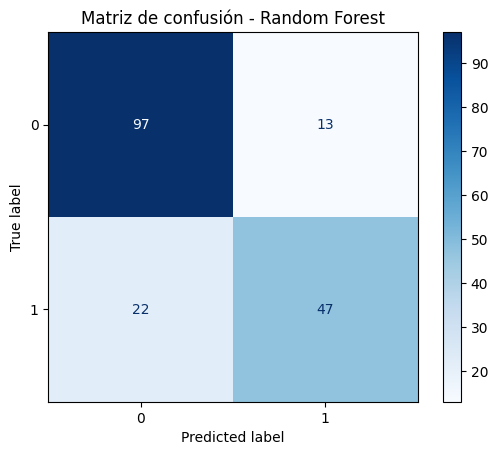

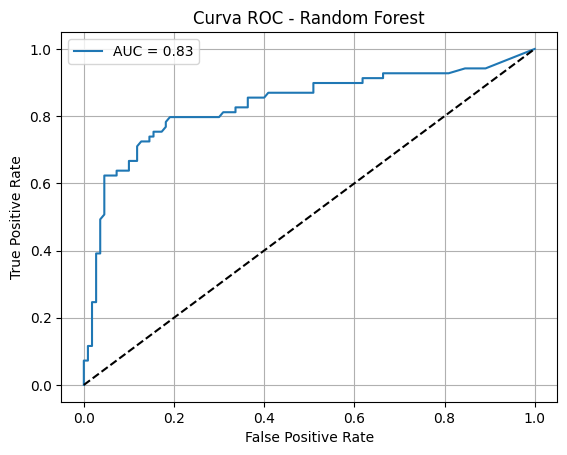

In [28]:
# Ejemplo con Random Forest
modelo_rf = modelos[1][1]
y_prediccion = modelo_rf.predict(X_prueba)
y_probabilidad = modelo_rf.predict_proba(X_prueba)[:, 1]

# Matriz de confusión
cm = confusion_matrix(y_prueba, y_prediccion)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(cmap = 'Blues')
plt.title('Matriz de confusión - Random Forest')
plt.show()

# Curva ROC
fpr, tpr ,_ = roc_curve(y_prueba, y_probabilidad)
roc_auc = roc_auc_score(y_prueba, y_probabilidad)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC - Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


## ¿Que variables influyen mas en la supervivencia?
### Importancia de variables en Random Forest

Con el siguiente bloque puedo ver cuáles variables fueron más utiles para tomar decisiones en los árboles. Por ejemplo, `Fare` y `Sex` tienen una importancia alta, lo que quiere decir que se usaron mucho para dividir los nodos.

In [29]:
importances = modelo_rf.feature_importances_
for feature, importance in zip(X.columns, importances):
    print(f'{feature}: {importance:.4f}')

Pclass: 0.0853
Sex: 0.2646
Age: 0.2510
SibSp: 0.0498
Parch: 0.0389
Fare: 0.2750
Embarked_Q: 0.0122
Embarked_S: 0.0232


### Coeficientes en Regresión Logica

Con el siguiente bloque puedo ver cuáles variables tuvieron efecto positivo o negativo en regresión lineal. Por ejemplo, un coeficiente negativo en Sex (donde 0 = Hombre y 1 = Mujer) indicaria que ser mujer aumenta la probabilidad de supervivencia.

In [30]:
coef = modelos[0][1].coef_[0]
for feature, weight in zip(X.columns, coef):
    print(f'{feature}: {weight:.4f}')

Pclass: -1.0922
Sex: 2.5590
Age: -0.0386
SibSp: -0.2446
Parch: -0.0709
Fare: 0.0022
Embarked_Q: 0.2791
Embarked_S: -0.3823


## ¿Que modelo se comporto mejor y porque?
Aunque ambos modelos dieron la misma precisión, eso no significa que tienen el mismo comportamiento y para validar cual fue el mas adecuado podemos usar una validacion de Curva ROC y AUC.

Entonces el modelo con mayor AUC tiene mejor capacidad de distinguir entre las clases (sobrevivió o no sobrevivió), incluso si sus accuracy fueron iguales.

AUC Logistic Regression: 0.8443


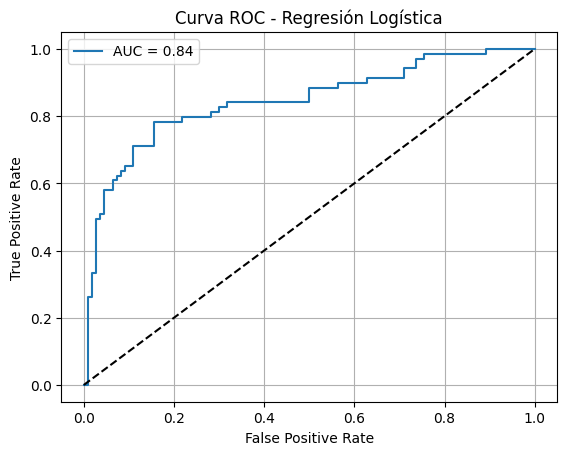

In [31]:
# Ejemplo con Random Forest
modelo_lr = modelos[0][1]
y_prediccion = modelo_rf.predict(X_prueba)
y_probabilidad_lr = modelo_lr.predict_proba(X_prueba)[:, 1]
auc_lr = roc_auc_score(y_prueba, y_probabilidad_lr)
print(f"AUC Logistic Regression: {auc_lr:.4f}")


# Curva ROC
fpr, tpr ,_ = roc_curve(y_prueba, y_probabilidad_lr)
roc_auc = roc_auc_score(y_prueba, y_probabilidad_lr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC - Regresión Logística')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# 🚢 Caso práctico: Predicción de supervivencia en el Titanic

### 🎯 Objetivo
Construir un modelo de clasificación supervisada para predecir si un pasajero sobrevivió, utilizando variables demográficas y de viaje como edad, sexo, clase socioeconómica, número de familiares a bordo, entre otras.

---

### 🧪 Pasos realizados

- Carga del dataset `train.csv` desde Kaggle
- Exploración inicial y análisis de valores nulos
- Imputación de edad con mediana y embarque con modo
- Eliminación de la variable `Cabin` por alta proporción de nulos
- Codificación binaria de `Sex` y dummies para `Embarked`
- Selección de variables relevantes para el modelo
- División en entrenamiento y prueba (`test_size=0.2`, `stratify=y`)
- Entrenamiento de modelos: Regresión Logística y Random Forest
- Evaluación con accuracy, matriz de confusión y curva ROC
- Análisis de importancia de variables y coeficientes

---

### 📊 Resultados

| Modelo              | Accuracy (%) | AUC (ROC) |
|---------------------|--------------|-----------|
| Regresión Logística | 80.45        | 0.84      |
| Random Forest       | 80.45        | 0.83      |

- Ambos modelos lograron la misma precisión, pero la regresión logística mostró una ligera ventaja en capacidad de discriminación (AUC).
- La matriz de confusión reveló errores balanceados entre falsos positivos y negativos.
- La variable `Sex` fue la más influyente en ambos modelos, seguida por `Pclass` y `Fare`.
- La imputación de edad y la codificación de variables categóricas permitieron estabilizar el entrenamiento sin pérdida de información relevante.

---

### 💬 Reflexión

> “Este ejercicio me permitió aplicar un flujo completo de clasificación binaria, desde la limpieza de datos hasta la interpretación de resultados. Aunque ambos modelos lograron la misma precisión, el análisis de AUC y coeficientes me permitió identificar diferencias sutiles en su comportamiento. La regresión logística ofreció mayor interpretabilidad, mientras que Random Forest mostró robustez ante variables no lineales. La visualización de la curva ROC y la matriz de confusión me ayudaron a entender el balance entre aciertos y errores. Este tipo de análisis me parece esencial para justificar decisiones de modelo en entornos reales.”

---

### 📎 Recursos utilizados

- Dataset: Titanic (`train.csv`) desde [Kaggle](https://www.kaggle.com/c/titanic/data)
- Librerías: `Pandas`, `Scikit-Learn`, `Matplotlib`, `NumPy`
- Entorno: `Jupyter Notebook`

---

### 📂 Estructura del proyecto

<>
/titanic_survival_prediction/ │ ├── titanic_model.ipynb ├── README.md ├── resultados/ │   ├── matriz_confusion_rf.png │   ├── matriz_confusion_lr.png │   ├── curva_roc_rf.png │   ├── curva_roc_lr.png │   └── importancia_variables.png